# BIB Tagger
https://github.com/KateRita/bib-tagger

# Find Body Box

In [177]:
import cv2
import os
import numpy as np

def getbodyboxes(image):
    #in: numpy image
    #out: list [(x,y,width,height)]

    faces = findfaces(image)

    bodyrectangles = findbodies(image,faces)

    return bodyrectangles


def findfaces(image):


    cascPath = "haarcascade_frontalface_default.xml"

    #cascPath = os.path.join(haarcascadeFolder, "haarcascade_upperbody.xml")
    #cascPath = os.path.join(haarcascadeFolder, "haarcascade_fullbody.xml")
    #cascPath = os.path.join(haarcascadeFolder, "haarcascade_russian_plate_number.xml")

    # Create the haar cascade
    faceCascade = cv2.CascadeClassifier(cascPath)

    # Read the image
    height, width, depth = image.shape
    scale = 1
    if (width > 1024):
        scale = 1024.0/width
        image = cv2.resize(image, None, fx=scale, fy=scale)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.05,
        minNeighbors=5,
        minSize=(30, 30),
    )

    return [scale_rect(face, 1/scale) for face in faces]

def scale_rect(rect, scale):
    return [int(value*scale) for value in rect]

def findbodies(image, faces):

    bodies = np.zeros_like(faces)
    bodiesindex = 0

    #for each face, draw a body
    for (x, y, facewidth, faceheight) in faces:
        #3*faceheight, 7/3 * facewidth, .5*faceheight below the face.
        bodyheight = 3 * faceheight
        bodywidth = 7/3 * facewidth
        y_body = y + faceheight + .5 * faceheight
        x_body = x + .5 * facewidth - .5 * bodywidth

        bodies[bodiesindex] = (x_body,y_body, bodywidth, bodyheight)
        bodiesindex = bodiesindex + 1

        #cv2.rectangle(image, (x_body, y_body), (x_body+bodywidth, y_body+bodyheight), (0, 255, 0), 2)

    return bodies



In [178]:
def drawboxes(image, boxes, color = (255,0,0)):

    # Draw a rectangle around the faces
    for (x, y, w, h) in boxes:
        cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)
        
    return image

def getSubImage(image, rectangle):
    #in: image, rectangle(x,y,width,height)
    #out: subimage

    (x,y,w,h) = rectangle

    return image[y:y+h,x:x+w,:]

In [179]:
# path = "4.jpg"
path = "../images/3KA_6436.JPG"
img = cv2.imread(path)
# Because OpenCV stores images in BGR order instead of RGB.
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [180]:
boxes = getbodyboxes(img)
boxes

array([[2465, 1513,  609,  783],
       [3187, 1444,  585,  753],
       [1683, 2176,  560,  720],
       [ 761, 2671,  473,  609],
       [1555,  856,  709,  912],
       [1120, 2310, 3278, 4215],
       [2354, 3344,  697,  897]])

In [181]:
img = getSubImage(img, boxes[0])

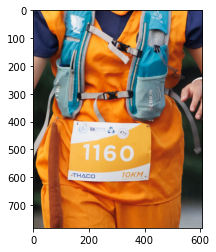

In [182]:
import matplotlib.pyplot as plt
# plt.figure(figsize = (20,20))
plt.imshow(img)

# Find BIB

In [183]:
import cv2
import numpy as np

#
# Takes an input image which is assumed to only have one bib and returns the
# four corners of the bib in the form of an opencv contour (vector of points,
# i.e vector((x1,y1),(x2,y2),(x3,y3),(x4,y4)) )
#
def find_bib(image):
    width, height, depth = image.shape

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY);
    #gray = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(gray,(5,5),0)

    #binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize=25, C=0);
    ret,binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU);
    #ret,binary = cv2.threshold(blurred, 170, 255, cv2.THRESH_BINARY);
    threshold_contours,hierarchy = find_contours(binary)

    edges = cv2.Canny(gray,175,200, 3)
    edge_contours,hierarchy = find_contours(edges)


    contours = threshold_contours + edge_contours
    rectangles = get_rectangles(contours)

    potential_bibs = [rect for rect in rectangles if is_potential_bib(rect, width*height)]

    ideal_aspect_ratio = 1.0
    potential_bibs = sorted(potential_bibs, key = lambda bib: abs(aspect_ratio(bib) - ideal_aspect_ratio))

    return potential_bibs[0] if len(potential_bibs) > 0 else np.array([[(0,0)],[(0,0)],[(0,0)],[(0,0)]])

#
# Checks that the size and aspect ratio of the contour is appropriate for a bib.
#
def is_potential_bib(rect, image_area):
    min_bib_size = image_area / 12;
    max_bib_size = image_area / 4;
    return (cv2.contourArea(rect) > min_bib_size and
            cv2.contourArea(rect) < max_bib_size and
            aspect_ratio(rect) > 0.75 and
            aspect_ratio(rect) < 2.5)

def aspect_ratio(rect):
    (x,y),(w,h),theta = cv2.minAreaRect(rect)
    return float(w) / float(h)

def find_bibs(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY);
    binary = cv2.GaussianBlur(gray,(5,5),0)
    ret,binary = cv2.threshold(binary, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU);
    #binary = cv2.adaptiveThreshold(binary, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    #ret,binary = cv2.threshold(binary, 190, 255, cv2.THRESH_BINARY);

    #lapl = cv2.Laplacian(image,cv2.CV_64F)
    #gray = cv2.cvtColor(lapl, cv2.COLOR_BGR2GRAY);
    #blurred = cv2.GaussianBlur(lapl,(5,5),0)
    #ret,binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU);
    #cv2.imwrite("lapl.jpg", lapl)

    edges = cv2.Canny(image,175,200)
    cv2.imwrite("edges.jpg", edges)
    binary = edges

    cv2.imwrite("binary.jpg", binary)
    contours,hierarchy = find_contours(binary)

    return get_rectangles(contours)

def find_contours(image):
    #return cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE);
    #return cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE);
    return cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE);

def get_rectangles(contours):
    rectangles = []
    for contour in contours:
        epsilon = 0.04*cv2.arcLength(contour,True)
        hull = cv2.convexHull(contour)
        approx = cv2.approxPolyDP(hull,epsilon,True)
        if (len(approx) == 4 and cv2.isContourConvex(approx)):
            rectangles.append(approx)

    return rectangles

def find_lines(img):
    edges = cv2.Canny(img,100,200)
    threshold = 60
    minLineLength = 10
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold, 0, minLineLength, 20);
    if (lines is None or len(lines) == 0):
        return

    #print lines
    for line in lines[0]:
        #print line
        cv2.line(img, (line[0],line[1]), (line[2],line[3]), (0,255,0), 2)
    cv2.imwrite("line_edges.jpg", edges)
    cv2.imwrite("lines.jpg", img)

def find_blobs(img):
    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()
     
    # Change thresholds
    params.minThreshold = 100;
    params.maxThreshold = 5000;
     
    # Filter by Area.
    params.filterByArea = True
    params.minArea = 200
     
    # Filter by Circularity
    params.filterByCircularity = False
    params.minCircularity = 0.785
     
    # Filter by Convexity
    params.filterByConvexity = False
    params.minConvexity = 0.87
     
    # Filter by Inertia
    #params.filterByInertia = True
    #params.minInertiaRatio = 0.01

    # Set up the detector with default parameters.
    detector = cv2.SimpleBlobDetector(params)
     
    # Detect blobs.
    keypoints = detector.detect(img)
    print(keypoints)
      
    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]),
            (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv2.imwrite("blobs.jpg", im_with_keypoints)

def find_keypoints(img):
    # Initiate FAST object with default values
    fast = cv2.FastFeatureDetector()

    # find and draw the keypoints
    kp = fast.detect(img,None)
    img2 = cv2.drawKeypoints(img, kp, color=(255,0,0))

    # Print all default params
    print("Threshold: ", fast.getInt('threshold'))
    print("nonmaxSuppression: ", fast.getBool('nonmaxSuppression'))
    #print "neighborhood: ", fast.getInt('type')
    print("Total Keypoints with nonmaxSuppression: ", len(kp))

    cv2.imwrite('fast_true.png',img2)


In [184]:
corners = find_bib(img)
print(corners)
bib_box = cv2.boundingRect(corners)
bib_box

[[[173 300]]

 [[415 415]]

 [[394 672]]

 [[124 609]]]


(124, 300, 292, 373)

In [185]:
bib = getSubImage(img, bib_box)

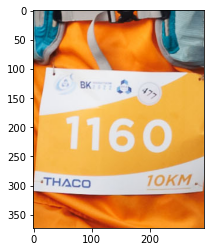

In [186]:
plt.imshow(bib)

In [187]:
height, width, depth = bib.shape
best_width = 256.0
scale = best_width / width
bib = cv2.resize(bib, None, fx=scale, fy=scale)

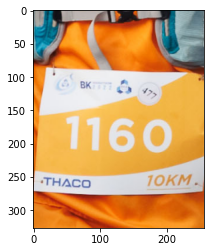

In [188]:
plt.imshow(bib)

# SWT

In [189]:
# -*- encoding: utf-8 -*-
#Adapted from: https://github.com/mypetyak/StrokeWidthTransform/blob/master/swt.py 4/23/16

from __future__ import division
from collections import defaultdict

import math
import os
import time

import numpy as np
import cv2
import scipy.sparse, scipy.spatial

t0 = time.clock()

diagnostics = False


class SWTScrubber(object):
    @classmethod
    def scrub(cls, image):
        """
        Apply Stroke-Width Transform to image.

        :param filepath: relative or absolute filepath to source image
        :return: numpy array representing result of transform
        """

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        canny, sobelx, sobely, theta = cls._create_derivative(gray)
        swt = cls._swt(theta, canny, sobelx, sobely)
        shapes = cls._connect_components(swt)
        swts, heights, widths, topleft_pts, images = cls._find_letters(swt, shapes)
        if(len(swts)==0):
            #didn't find any text, probably a bad face
            return None

        word_images = cls._find_words(swts, heights, widths, topleft_pts, images)

        final_mask = np.zeros(swt.shape)
        for word in word_images:
            final_mask += word
        return final_mask

    @classmethod
    def _create_derivative(cls, img):
        edges = cv2.Canny(img, 175, 320, apertureSize=3)
        # Create gradient map using Sobel
        sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=-1)
        sobely64f = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=-1)

        theta = np.arctan2(sobely64f, sobelx64f)
        if diagnostics:
            cv2.imwrite('edges.jpg',edges)
            cv2.imwrite('sobelx64f.jpg', np.absolute(sobelx64f))
            cv2.imwrite('sobely64f.jpg', np.absolute(sobely64f))
            # amplify theta for visual inspection
            theta_visible = (theta + np.pi)*255/(2*np.pi)
            cv2.imwrite('theta.jpg', theta_visible)
        return (edges, sobelx64f, sobely64f, theta)

    @classmethod
    def _swt(self, theta, edges, sobelx64f, sobely64f):
        # create empty image, initialized to infinity
        swt = np.empty(theta.shape)
        swt[:] = np.Infinity
        rays = []

        print(time.clock() - t0)

        # now iterate over pixels in image, checking Canny to see if we're on an edge.
        # if we are, follow a normal a ray to either the next edge or image border
        # edgesSparse = scipy.sparse.coo_matrix(edges)
        step_x_g = -1 * sobelx64f
        step_y_g = -1 * sobely64f
        mag_g = np.sqrt( step_x_g * step_x_g + step_y_g * step_y_g )
        grad_x_g = step_x_g / mag_g
        grad_y_g = step_y_g / mag_g

        for x in range(edges.shape[1]):
            for y in range(edges.shape[0]):
                if edges[y, x] > 0:
                    step_x = step_x_g[y, x]
                    step_y = step_y_g[y, x]
                    mag = mag_g[y, x]
                    grad_x = grad_x_g[y, x]
                    grad_y = grad_y_g[y, x]
                    ray = []
                    ray.append((x, y))
                    prev_x, prev_y, i = x, y, 0
                    while True:
                        i += 1
                        cur_x = math.floor(x + grad_x * i)
                        cur_y = math.floor(y + grad_y * i)

                        if cur_x != prev_x or cur_y != prev_y:
                            # we have moved to the next pixel!
                            try:
                                # Detect if we have just "stepped through" a line on the diagonal
                                if (prev_x != x and prev_y != y and cur_x != prev_x and cur_y != prev_y):
                                    if edges[cur_y, prev_x] > 0 and edges[prev_y, cur_x] > 0:
                                        break

                                if edges[cur_y, cur_x] > 0:
                                    # found edge,
                                    ray.append((cur_x, cur_y))
                                    theta_point = theta[y, x]
                                    alpha = theta[cur_y, cur_x]
                                    val = grad_x * -grad_x_g[cur_y, cur_x] + grad_y * -grad_y_g[cur_y, cur_x]
                                    if (val < -1.0):
                                        val = -1.0
                                    if (val > 1.0):
                                        val = 1.0
                                    if math.acos(val) < np.pi/2.0:
                                        thickness = math.sqrt( (cur_x - x) * (cur_x - x) + (cur_y - y) * (cur_y - y) )
                                        for (rp_x, rp_y) in ray:
                                            swt[rp_y, rp_x] = min(thickness, swt[rp_y, rp_x])
                                        rays.append(ray)
                                    break
                                # this is positioned at end to ensure we don't add a point beyond image boundary
                                ray.append((cur_x, cur_y))
                            except IndexError:
                                # reached image boundary
                                break
                            prev_x = cur_x
                            prev_y = cur_y

        # Compute median SWT
        for ray in rays:
            median = np.median([swt[y, x] for (x, y) in ray])
            for (x, y) in ray:
                swt[y, x] = min(median, swt[y, x])
        if diagnostics:
            cv2.imwrite('swt.jpg', swt * 100)

        return swt

    @classmethod
    def _connect_components(cls, swt):
        # STEP: Compute distinct connected components
        # Implementation of disjoint-set
        class Label(object):
            def __init__(self, value):
                self.value = value
                self.parent = self
                self.rank = 0
            def __eq__(self, other):
                if type(other) is type(self):
                    return self.value == other.value
                else:
                    return False
            def __ne__(self, other):
                return not self.__eq__(other)

        ld = {}

        def MakeSet(x):
            try:
                return ld[x]
            except KeyError:
                item = Label(x)
                ld[x] = item
                return item

        def Find(item):
            # item = ld[x]
            if item.parent != item:
                item.parent = Find(item.parent)
            return item.parent

        def Union(x, y):
            """
            :param x:
            :param y:
            :return: root node of new union tree
            """
            x_root = Find(x)
            y_root = Find(y)
            if x_root == y_root:
                return x_root

            if x_root.rank < y_root.rank:
                x_root.parent = y_root
                return y_root
            elif x_root.rank > y_root.rank:
                y_root.parent = x_root
                return x_root
            else:
                y_root.parent = x_root
                x_root.rank += 1
                return x_root

        # apply Connected Component algorithm, comparing SWT values.
        # components with a SWT ratio less extreme than 1:3 are assumed to be
        # connected. Apply twice, once for each ray direction/orientation, to
        # allow for dark-on-light and light-on-dark texts
        trees = {}
        # Assumption: we'll never have more than 65535-1 unique components
        label_map = np.zeros(shape=swt.shape, dtype=np.uint16)
        next_label = 1
        # First Pass, raster scan-style
        swt_ratio_threshold = 3.0
        for y in range(swt.shape[0]):
            for x in range(swt.shape[1]):
                sw_point = swt[y, x]
                if sw_point < np.Infinity and sw_point > 0:
                    neighbors = [(y, x-1),   # west
                                 (y-1, x-1), # northwest
                                 (y-1, x),   # north
                                 (y-1, x+1)] # northeast
                    connected_neighbors = None
                    neighborvals = []

                    for neighbor in neighbors:
                        # west
                        try:
                            sw_n = swt[neighbor]
                            label_n = label_map[neighbor]
                        except IndexError:
                            continue
                        if label_n > 0 and sw_n / sw_point < swt_ratio_threshold and sw_point / sw_n < swt_ratio_threshold:
                            neighborvals.append(label_n)
                            if connected_neighbors:
                                connected_neighbors = Union(connected_neighbors, MakeSet(label_n))
                            else:
                                connected_neighbors = MakeSet(label_n)

                    if not connected_neighbors:
                        # We don't see any connections to North/West
                        trees[next_label] = (MakeSet(next_label))
                        label_map[y, x] = next_label
                        next_label += 1
                    else:
                        # We have at least one connection to North/West
                        label_map[y, x] = min(neighborvals)
                        # For each neighbor, make note that their respective connected_neighbors are connected
                        # for label in connected_neighbors. @todo: do I need to loop at all neighbor trees?
                        trees[connected_neighbors.value] = Union(trees[connected_neighbors.value], connected_neighbors)

        # Second pass. re-base all labeling with representative label for each connected tree
        layers = {}
        contours = defaultdict(list)
        for x in range(swt.shape[1]):
            for y in range(swt.shape[0]):
                if label_map[y, x] > 0:
                    item = ld[label_map[y, x]]
                    common_label = Find(item).value
                    label_map[y, x] = common_label
                    contours[common_label].append([x, y])
                    try:
                        layer = layers[common_label]
                    except KeyError:
                        layers[common_label] = np.zeros(shape=swt.shape, dtype=np.uint16)
                        layer = layers[common_label]

                    layer[y, x] = 1
        return layers

    @classmethod
    def _find_letters(cls, swt, shapes):
        # STEP: Discard shapes that are probably not letters
        swts = []
        heights = []
        widths = []
        topleft_pts = []
        images = []

        for label,layer in shapes.items():
            (nz_y, nz_x) = np.nonzero(layer)
            east, west, south, north = max(nz_x), min(nz_x), max(nz_y), min(nz_y)
            width, height = east - west, south - north

            if width < 8 or height < 8:
                continue

            if width / height > 10 or height / width > 10:
                continue

            if float(width) / height > 3.0:
                continue

            diameter = math.sqrt(width * width + height * height)
            median_swt = np.median(swt[(nz_y, nz_x)])
            if diameter / median_swt > 10:
                continue

            if width / layer.shape[1] > 0.4 or height / layer.shape[0] > 0.4:
                continue

            if diagnostics:
                print(" written to image.")
                cv2.imwrite('layer'+ str(label) +'.jpg', layer * 255)

            # we use log_base_2 so we can do linear distance comparison later using k-d tree
            # ie, if log2(x) - log2(y) > 1, we know that x > 2*y
            # Assumption: we've eliminated anything with median_swt == 1
            swts.append([math.log(median_swt, 2)])
            heights.append([math.log(height, 2)])
            topleft_pts.append(np.asarray([north, west]))
            widths.append(width)
            images.append(layer)

        return swts, heights, widths, topleft_pts, images

    @classmethod
    def _find_words(cls, swts, heights, widths, topleft_pts, images):
        # Find all shape pairs that have similar median stroke widths

        #print 'SWTS'
        #print swts
        #print 'DONESWTS'

        swt_tree = scipy.spatial.KDTree(np.asarray(swts))
        stp = swt_tree.query_pairs(1)

        # Find all shape pairs that have similar heights
        height_tree = scipy.spatial.KDTree(np.asarray(heights))
        htp = height_tree.query_pairs(1)

        # Intersection of valid pairings
        isect = htp.intersection(stp)

        chains = []
        pairs = []
        pair_angles = []
        for pair in isect:
            left = pair[0]
            right = pair[1]
            widest = max(widths[left], widths[right])
            distance = np.linalg.norm(topleft_pts[left] - topleft_pts[right])
            if distance < widest * 1.5:
                delta_yx = topleft_pts[left] - topleft_pts[right]
                angle = np.arctan2(delta_yx[0], delta_yx[1])
                if angle < 0:
                    angle += np.pi

                pairs.append(pair)
                pair_angles.append(np.asarray([angle]))

        atp = []
        if len(pair_angles) > 0:
            angle_tree = scipy.spatial.KDTree(np.asarray(pair_angles))
            atp = angle_tree.query_pairs(np.pi/12)

        for pair_idx in atp:
            pair_a = pairs[pair_idx[0]]
            pair_b = pairs[pair_idx[1]]
            left_a = pair_a[0]
            right_a = pair_a[1]
            left_b = pair_b[0]
            right_b = pair_b[1]

            # @todo - this is O(n^2) or similar, extremely naive. Use a search tree.
            added = False
            for chain in chains:
                if left_a in chain:
                    chain.add(right_a)
                    added = True
                elif right_a in chain:
                    chain.add(left_a)
                    added = True
            if not added:
                chains.append(set([left_a, right_a]))
            added = False
            for chain in chains:
                if left_b in chain:
                    chain.add(right_b)
                    added = True
                elif right_b in chain:
                    chain.add(left_b)
                    added = True
            if not added:
                chains.append(set([left_b, right_b]))

        word_images = []
        for chain in [c for c in chains if len(c) > 1 and len(c) < 6]:
            for idx in chain:
                word_images.append(images[idx])
                # cv2.imwrite('keeper'+ str(idx) +'.jpg', images[idx] * 255)
                # final += images[idx]

        return word_images

C:\Users\rin2401\miniconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  from ipykernel import kernelapp as app


In [190]:
SWTbib = SWTScrubber.scrub(bib)

C:\Users\rin2401\miniconda3\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\rin2401\miniconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide
C:\Users\rin2401\miniconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide


1.4840407000001505


In [191]:
SWTbib

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [192]:
# cv2.imwrite("test.jpg", (255-(255*SWTbib)))

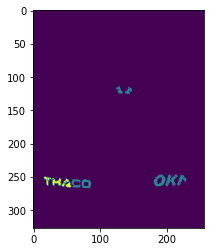

In [193]:
swt_img = 255 - (255 * SWTbib)
# swt_img = cv2.cvtColor(swt_img, cv2.COLOR_BGR2RGB)
plt.imshow(SWTbib)

# OCR
https://github.com/UB-Mannheim/tesseract/wiki

In [194]:
from PIL import Image

im_pil = Image.fromarray(swt_img).convert('RGB')

In [195]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = 'C:\Program Files\Tesseract-OCR/tesseract.exe'

In [196]:
import re
from pytesseract import image_to_string

bib_number = image_to_string(bib, config="--psm 8 digits")
print(bib_number)
bib_number = re.sub("[^0-9]", "", bib_number)
bib_number

''